# Enhanced Fake News Classifier

## Overview
This notebook implements an enhanced fake news classifier with:
- Robust text preprocessing (cleaning, stopword removal, lemmatization)
- Advanced feature engineering (length, punctuation, lexical diversity, subject, dates)
- TF-IDF vectorization and numerical feature scaling
- Multiple models (Logistic Regression, Random Forest, Gradient Boosting, SVM)
- Soft-voting ensemble and cross-validation
- Predictions on validation set with confidence scores

Run cells top-to-bottom.


In [1]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# NLTK data
for pkg, path in [('punkt','tokenizers/punkt'),('stopwords','corpora/stopwords'),('wordnet','corpora/wordnet')]:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(pkg)

print('Setup complete')


Setup complete


[nltk_data] Downloading package wordnet to /Users/sergej/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load data
print('Loading data...')
train_data = pd.read_csv('dataset/data.csv')
validation_data = pd.read_csv('dataset/validation_data.csv')
print(f'Training: {train_data.shape}, Validation: {validation_data.shape}')


Loading data...
Training: (39942, 5), Validation: (4956, 5)


In [3]:
# Preprocessing functions
def clean_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

def remove_stopwords(text):
    if pd.isna(text):
        return ''
    try:
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        return ' '.join([w for w in words if w.lower() not in stop_words])
    except:
        return text

def lemmatize_text(text):
    if pd.isna(text):
        return ''
    try:
        lemmatizer = WordNetLemmatizer()
        words = word_tokenize(text)
        return ' '.join([lemmatizer.lemmatize(w) for w in words])
    except:
        return text

def preprocess_text(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

print('Preprocessing functions ready')


Preprocessing functions ready


In [4]:
# Advanced date parsing

def parse_dates_robust(date_series):
    formats = ['%B %d, %Y', '%d-%b-%y', '%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y']
    parsed_dates = pd.Series([pd.NaT] * len(date_series), index=date_series.index)
    for fmt in formats:
        try:
            temp = pd.to_datetime(date_series, format=fmt, errors='coerce')
            mask = parsed_dates.isna() & temp.notna()
            parsed_dates[mask] = temp[mask]
        except:
            continue
    return parsed_dates

print('Date parser ready')


Date parser ready


In [5]:
# Feature engineering
print('Engineering features...')

# Process text
data = train_data.copy()
data['text_processed'] = data['text'].apply(preprocess_text)
data['title_processed'] = data['title'].apply(preprocess_text)

# Basic lengths
data['text_length'] = data['text'].str.len()
data['title_length'] = data['title'].str.len()
data['word_count'] = data['text'].str.split().str.len()
data['title_word_count'] = data['title'].str.split().str.len()

# Advanced text features
data['avg_word_length'] = data['text'].str.split().str.join(' ').str.len() / data['word_count']
data['title_avg_word_length'] = data['title'].str.split().str.join(' ').str.len() / data['title_word_count']

# Punctuation features (escape regex)
data['exclamation_count'] = data['text'].str.count(r'!')
data['question_count'] = data['text'].str.count(r'\?')
data['quote_count'] = data['text'].str.count(r'"')
data['capital_ratio'] = data['text'].str.count(r'[A-Z]') / data['text_length']

# Lexical diversity
data['unique_words_ratio'] = data['text_processed'].str.split().apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
data['title_unique_words_ratio'] = data['title_processed'].str.split().apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)

# Subject encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['subject_encoded'] = le.fit_transform(data['subject'])
subject_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
DEFAULT_SUBJECT = 0

# Date features
data['date_clean'] = data['date'].str.strip()
data['date_parsed'] = parse_dates_robust(data['date_clean'])
data['year'] = data['date_parsed'].dt.year
data['month'] = data['date_parsed'].dt.month
data['day_of_week'] = data['date_parsed'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

numerical_features = [
    'text_length','title_length','word_count','title_word_count',
    'avg_word_length','title_avg_word_length',
    'exclamation_count','question_count','quote_count','capital_ratio',
    'unique_words_ratio','title_unique_words_ratio',
    'subject_encoded','year','month','day_of_week','is_weekend'
]

print('Features ready')


Engineering features...
Features ready


In [6]:
# Train/test split and vectorization
X_text = data['text_processed']
X_num = data[numerical_features].fillna(0)
y = data['label']

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,3),
    min_df=3,
    max_df=0.8,
    sublinear_tf=True
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Scale numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_num_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_num_scaled])

print('Vectorization and scaling complete')


Vectorization and scaling complete


In [7]:
# Train models
lr_model = LogisticRegression(random_state=42, max_iter=2000, C=1.0)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=20)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_model = SVC(random_state=42, probability=True, kernel='rbf')
ensemble_model = VotingClassifier(
    estimators=[('lr', lr_model), ('rf', rf_model), ('gb', gb_model), ('svm', svm_model)],
    voting='soft'
)

models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'SVM': svm_model,
    'Ensemble': ensemble_model
}

results = {}
for name, model in models.items():
    model.fit(X_train_combined, y_train)
    y_pred = model.predict(X_test_combined)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} ({results[best_model_name]:.4f})")


Logistic Regression: 0.9999
Random Forest: 1.0000
Gradient Boosting: 1.0000
SVM: 0.9996
Ensemble: 0.9999

Best model: Random Forest (1.0000)


In [8]:
# Cross-validation
cv_scores = cross_val_score(best_model, X_train_combined, y_train, cv=5)
print('CV scores:', cv_scores)
print('CV mean:', cv_scores.mean(), '+/-', cv_scores.std()*2)


CV scores: [0.99984353 0.99953059 0.99968706 0.99968701 0.99968701]
CV mean: 0.9996870403386608 +/- 0.0001979206855330111


In [13]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Fake','Real']))


Accuracy: 0.9998748278883465
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3989
        Real       1.00      1.00      1.00      4000

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



Accuracy: 0.9998748278883465
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3989
        Real       1.00      1.00      1.00      4000

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



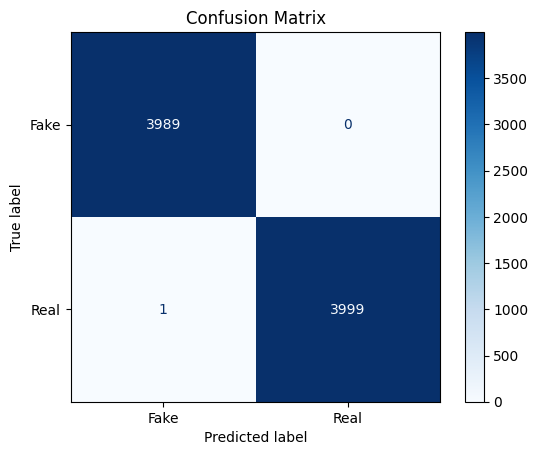

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [9]:
# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    text_size = X_train_tfidf.shape[1]
    text_imps = importances[:text_size]
    top_idx = np.argsort(text_imps)[-10:]
    top_feats = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_idx]
    print('Top text features:')
    for f, w in zip(top_feats, text_imps[top_idx]):
        print(f'{f}: {w:.4f}')
    num_imps = importances[text_size:]
    print('\nNumerical features:')
    for f, w in zip(numerical_features, num_imps):
        print(f'{f}: {w:.4f}')
else:
    print('Model has no feature_importances_ attribute')


Top text features:
like: 0.0081
know: 0.0092
minister: 0.0101
washington: 0.0114
image: 0.0173
image via: 0.0177
washington reuters: 0.0203
via: 0.0279
said: 0.0375
reuters: 0.1008

Numerical features:
text_length: 0.0067
title_length: 0.0499
word_count: 0.0049
title_word_count: 0.0377
avg_word_length: 0.0096
title_avg_word_length: 0.0003
exclamation_count: 0.0145
question_count: 0.0145
quote_count: 0.0002
capital_ratio: 0.0016
unique_words_ratio: 0.0015
title_unique_words_ratio: 0.0013
subject_encoded: 0.0980
year: 0.0314
month: 0.0280
day_of_week: 0.0251
is_weekend: 0.0002


In [10]:
# Predict on validation data
val = validation_data.copy()
val['text_processed'] = val['text'].apply(preprocess_text)
val['title_processed'] = val['title'].apply(preprocess_text)
val['text_length'] = val['text'].str.len()
val['title_length'] = val['title'].str.len()
val['word_count'] = val['text'].str.split().str.len()
val['title_word_count'] = val['title'].str.split().str.len()
val['avg_word_length'] = val['text'].str.split().str.join(' ').str.len() / val['word_count']
val['title_avg_word_length'] = val['title'].str.split().str.join(' ').str.len() / val['title_word_count']
val['exclamation_count'] = val['text'].str.count(r'!')
val['question_count'] = val['text'].str.count(r'\?')
val['quote_count'] = val['text'].str.count(r'"')
val['capital_ratio'] = val['text'].str.count(r'[A-Z]') / val['text_length']
val['unique_words_ratio'] = val['text_processed'].str.split().apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
val['title_unique_words_ratio'] = val['title_processed'].str.split().apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)

# Subject encoding with unseen handling
val['subject_encoded'] = val['subject'].map(subject_mapping).fillna(DEFAULT_SUBJECT).astype(int)

# Date features
val['date_clean'] = val['date'].str.strip()
val['date_parsed'] = parse_dates_robust(val['date_clean'])
val['year'] = val['date_parsed'].dt.year
val['month'] = val['date_parsed'].dt.month
val['day_of_week'] = val['date_parsed'].dt.dayofweek
val['is_weekend'] = val['day_of_week'].isin([5, 6]).astype(int)

X_val_text = val['text_processed']
X_val_num = val[numerical_features].fillna(0)
X_val_num_scaled = scaler.transform(X_val_num)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_val_combined = hstack([X_val_tfidf, X_val_num_scaled])

val_pred = best_model.predict(X_val_combined)
val_proba = best_model.predict_proba(X_val_combined)

submission = pd.DataFrame({
    'id': range(len(val)),
    'label': val_pred,
    'probability_fake': val_proba[:, 0],
    'probability_real': val_proba[:, 1],
    'confidence': np.max(val_proba, axis=1)
})

submission.head()


,id,label,probability_fake,probability_real,confidence
0,0,1,0.071543,0.928457,0.928457
1,1,1,0.178441,0.821559,0.821559
2,2,1,0.128439,0.871561,0.871561
3,3,1,0.053886,0.946114,0.946114
4,4,1,0.077223,0.922777,0.922777


In [11]:
# Save predictions
submission.to_csv('enhanced_fake_news_predictions.csv', index=False)
print("Saved to enhanced_fake_news_predictions.csv")
print('Distribution:')
print(submission['label'].value_counts(normalize=True).rename({0:'fake',1:'real'}))


Saved to enhanced_fake_news_predictions.csv
Distribution:
label
fake    0.702986
real    0.297014
Name: proportion, dtype: float64


In [12]:
# Save validation with predicted labels into dataset
import os

# Try to use in-memory validation data if present; otherwise read from disk
try:
    original_val = validation_data.copy()
except NameError:
    original_val = pd.read_csv('dataset/validation_data.csv')

# Ensure lengths match
assert len(original_val) == len(submission), 'Length mismatch between validation and predictions'

labeled_val = original_val.copy()
labeled_val['label'] = submission['label'].values

out_path = os.path.join('dataset', 'validation_data_labeled.csv')
labeled_val.to_csv(out_path, index=False)
print(f"Saved labeled validation to: {out_path}")


Saved labeled validation to: dataset/validation_data_labeled.csv
